In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.axes import Axes
from visualization.scripts.plot_utils import filter_outliers
import helpers.project_config as cfg

from __future__ import annotations
import re
from datetime import datetime
from typing import Iterable
from IPython.display import display

## Explore Developer Data

In [2]:
df = pd.read_csv(cfg.commit_level_dataset_path_normalized)
df.shape

(86483, 19)

In [3]:
df.columns

Index(['genai_period', 'term', 'project', 'author_name', 'author_email',
       'date', 'repository', 'insertions', 'deletions', 'total_lines',
       'files_changed', 'diff_lines', 'unit_size_(dmm)', 'complexity_(dmm)',
       'interface_(dmm)', 'commit_hash', 'merge_commit', 'default_branch',
       'dev'],
      dtype='object')

In [4]:
# a developer is the combination from project and dev column
# calculate how many commits a developer made
# A developer is identified by (project, dev); count commits per developer
commits_per_dev = (
    df.dropna(subset=["project", "dev"])
    .groupby(["project", "dev"])
    .size()
    .reset_index(name="n_commits")
)
commits_per_dev.sort_values(by="n_commits", ascending=False).head(5)

project  dev  n_commits
982       320  1.0        263
1136      370  1.0        212
1751      564  1.0        212
1293      420  1.0        209
191        60  1.0        195

C:\Users\yanni\AppData\Local\Temp\ipykernel_20568\1895099006.py:3: UserWarning: The palette list has more values (10) than needed (1), which may not be intended.
  sns.scatterplot(dfsc, x=dfsc.index, y=dfsc['n_commits'], hue="dev", palette=sns.color_palette("bright"))


<Axes: xlabel='None', ylabel='n_commits'>

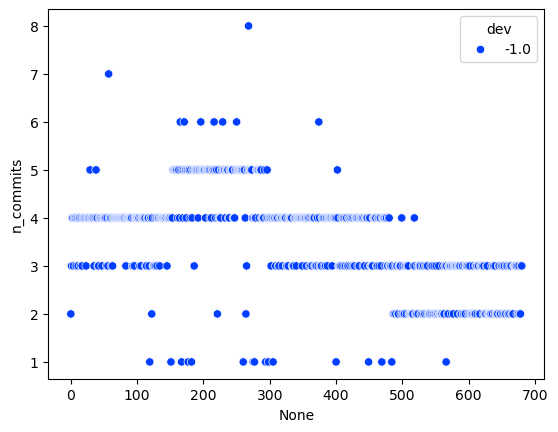

In [5]:
dfsc = commits_per_dev[commits_per_dev['dev'] == -1].reset_index(drop=True)
# dfsc = commits_per_dev
sns.scatterplot(dfsc, x=dfsc.index, y=dfsc['n_commits'], hue="dev", palette=sns.color_palette("bright"))
# dfsc.head()

In [6]:
commits_per_dev['n_commits'].value_counts().head(15)

n_commits
4     277
3     192
2     115
5     104
1      30
41     27
33     25
43     24
53     23
49     22
51     22
47     21
54     21
22     21
66     20
Name: count, dtype: int64

n_commits
151     1
154     1
178     1
132     1
164     1
       ..
53     23
43     24
33     25
41     27
1      30
Name: count, Length: 163, dtype: int64

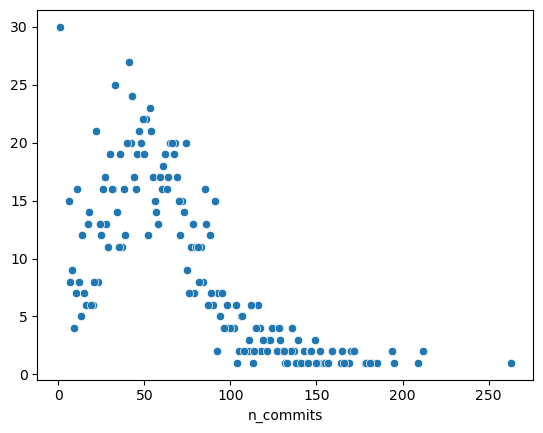

In [7]:
# How many developer commited how often
vc = commits_per_dev["n_commits"].value_counts(ascending=True)
vc_trim = vc.iloc[:-4]  # drop 4 largest n_commits values

sns.scatterplot(x=vc_trim.index, y=vc_trim.values)
vc_trim

## Plots Creation

### Methods

In [8]:
# filter_outliers moved to plot_utils.py because also needed in statistics.ipynb

In [9]:
def create_scatterplot(
    dataframe: pd.DataFrame,
    column: str,
    ax = None,
    x  = None,
    hue = "term",
    palette = cfg.TERM_COLORS,
) -> Axes:
    """
    Create a scatter plot of `column` against the row index or a chosen
    column.

    Parameters:
        dataframe: DataFrame containing the data to plot.
        column: Name of the numeric column to plot on the y-axis.
        ax: Optional matplotlib Axes to draw on. If None, seaborn creates one.
        x: Optional column name to use as x-values. If None, the row index is
           used.
        hue: Column name to use for color encoding (default "term").
        palette: Optional palette mapping for hue; defaults to TERM_COLORS.

    Returns:
        The matplotlib Axes object containing the plot.

    Raises:
        ValueError: If `column` (or `x`, if provided) is missing or if
                    `column` is not numeric.
    """
    if column not in dataframe.columns:
        raise ValueError(f"Column {column!r} not found in the DataFrame.")
    if x is not None and x not in dataframe.columns:
        raise ValueError(f"Column {x!r} not found in the DataFrame.")

    col = dataframe[column]
    if not pd.api.types.is_numeric_dtype(col):
        raise ValueError(f"Column {column!r} must have a numeric dtype.")

    df = dataframe.reset_index(drop=True)
    plot_x = df.index if x is None else df[x]

    res_ax = sns.scatterplot(
        data=df,
        x=plot_x,
        y=column,
        ax=ax,
        hue=hue,
        palette=palette,
    )

    return res_ax

In [10]:
MEAN_TEXT_FORMAT = "{:.1f}" # rounded to 1 digit behind the comma
MEAN_TEXT_FONTSIZE = 9
MEAN_TEXT_FONTWEIGHT = "bold"
MEAN_TEXT_BBOX = { # white background box
    "facecolor": "white",
    "alpha": 0.6,
    "edgecolor": "none",
    "pad": 1,
}

def add_mean_labels(
    dataframe: pd.DataFrame,
    column: str,
    ax: Axes,
    *,
    x = None,
    term_col: str = "term",
    fmt: str = MEAN_TEXT_FORMAT,
    fontsize: int = MEAN_TEXT_FONTSIZE,
    fontweight: str = MEAN_TEXT_FONTWEIGHT,
    bbox = MEAN_TEXT_BBOX,
) -> Axes:
    """
    Add per-term mean labels for `column` onto an existing Axes.

    The mean is computed per `term_col` group. The label is placed at the
    horizontal midpoint of each term group:
      - If `x` is None: uses the row index (after reset) to determine midpoints.
      - If `x` is provided: uses that column's values to determine midpoints.
    

    Parameters:
        dataframe: DataFrame containing the data.
        column: Name of the numeric column for which to compute means.
        ax: Matplotlib Axes to annotate.
        x: Optional column name to use as x-values. If None, uses row index.
        term_col: Column name defining the term groups (default "term").
        fmt: Format string for the mean label (default "{:.1f}").
        fontsize: Font size for labels.
        fontweight: Font weight for labels.
        bbox: bbox dict for label background.

    Returns:
        The same Axes passed in, with annotations added.

    Raises:
        ValueError: If required columns are missing or `column` is not numeric.
    """
    if column not in dataframe.columns:
        raise ValueError(f"Column {column!r} not found in the DataFrame.")
    if term_col not in dataframe.columns:
        raise ValueError(f"Column {term_col!r} not found in the DataFrame.")
    if x is not None and x not in dataframe.columns:
        raise ValueError(f"Column {x!r} not found in the DataFrame.")

    col = dataframe[column]
    if not pd.api.types.is_numeric_dtype(col):
        raise ValueError(f"Column {column!r} must have a numeric dtype.")

    df = dataframe.reset_index(drop=True).copy()
    df["_plot_x"] = df.index if x is None else df[x]

    # calculate position for each term
    term_means = df.groupby(term_col, dropna=False)[column].mean()
    term_x_mids = df.groupby(term_col, dropna=False)["_plot_x"].median()

    for term in term_means.index:
        mean_val = term_means.loc[term]
        x_mid = term_x_mids.loc[term]
        if pd.isna(mean_val) or pd.isna(x_mid):
            continue

        # Draws the text label fmt.format(mean_val) at coordinates (x_mid, mean_val) on the plot.
        ax.text(
            x_mid,
            mean_val,
            fmt.format(mean_val),
            ha="center",
            va="center",
            fontsize=fontsize,
            fontweight=fontweight,
            bbox=bbox,
        )

    return ax


In [11]:
def create_violinplot(
    dataframe: pd.DataFrame,
    column: str,
    ax = None,
    x  = "term",
    palette = cfg.TERM_COLORS,
    inner: str = "box",
) -> Axes:
    """
    Create a violin plot of `column` grouped by `x`.

    Args:
        dataframe: DataFrame containing the data.
        column: Name of the numeric column to plot on the y-axis.
        ax: Optional matplotlib Axes to draw on. If None, seaborn creates one.
        x: Name of the categorical column to group by (default "term").
        palette: Optional palette mapping or name; defaults to TERM_COLORS.
        inner: How to draw the inner representation (passed to seaborn.violinplot).

    Returns:
        The matplotlib Axes containing the plot.

    Raises:
        ValueError: If required columns are missing or `column` is not numeric.
    """
    if column not in dataframe.columns:
        raise ValueError(f"Column {column!r} not found in the DataFrame.")
    if x not in dataframe.columns:
        raise ValueError(f"Column {x!r} not found in the DataFrame.")
    if not pd.api.types.is_numeric_dtype(dataframe[column]):
        raise ValueError(f"Column {column!r} must be numeric to plot a violin.")

    res_ax = sns.violinplot(
        data=dataframe,
        x=x,
        y=column,
        ax=ax,
        hue=x,
        palette=palette,
        inner=inner,
    )
    return res_ax

## General Preprocessing

### Pipeline

In [12]:
_FILENAME_SAFE_RE = re.compile(r"[^A-Za-z0-9._-]+")


def _safe_filename(text: str) -> str:
    return _FILENAME_SAFE_RE.sub("_", text).strip("_")


def plot_metrics_and_save(
    df: pd.DataFrame,
    cols: Iterable[str],
    *,
    out_dir: str | Path = cfg.plots_path,
    save: bool = False,
    date_fmt: str = "%y%m%d",
    dpi: int = 200,
) -> None:
    """
    For each column in `cols`, filters outliers, then creates + displays:
      - a scatter plot (with mean labels)
      - a violin plot

    Each plot is created on a fresh figure (so it behaves like separate notebook cells)
    and is saved to `out_dir` with a timestamped filename.

    """
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)
    stamp = datetime.now().strftime(date_fmt)

    for col in cols:
        filtered_df = filter_outliers(df, col)

        # --- Scatter (fresh fig/ax) ---
        fig_scatter, ax_scatter = plt.subplots()
        scatter_ax = create_scatterplot(filtered_df, col, ax=ax_scatter)
        add_mean_labels(filtered_df, col, ax=scatter_ax)

        scatter_name = f"plot_scatter_{_safe_filename(col)}_{stamp}.svg"
        scatter_path = out_dir / scatter_name
        fig_scatter.tight_layout()
        if save:
            fig_scatter.savefig(scatter_path, dpi=dpi, bbox_inches="tight", format="png")
        display(fig_scatter)
        plt.close(fig_scatter)

        # --- Violin (fresh fig/ax) ---
        fig_violin, ax_violin = plt.subplots()
        violin_ax = create_violinplot(filtered_df, col, ax=ax_violin)

        violin_name = f"plot_violin_{_safe_filename(col)}_{stamp}.svg"
        violin_path = out_dir / violin_name
        fig_violin.tight_layout()
        if save:
            fig_violin.savefig(violin_path, dpi=dpi, bbox_inches="tight", format="png")
        display(fig_violin)
        plt.close(fig_violin)

        print(f"Saved: {scatter_path.name} | {violin_path.name}")



In [13]:
_FILENAME_SAFE_RE = re.compile(r"[^A-Za-z0-9._-]+")


def _safe_filename(text: str) -> str:
    return _FILENAME_SAFE_RE.sub("_", text).strip("_")


def plot_metrics_and_save(
    df: pd.DataFrame,
    cols: Iterable[str],
    *,
    out_dir: str | Path = cfg.plots_path,
    save: bool = False,
    date_fmt: str = "%y%m%d",
    dpi: int = 200,
) -> None:
    """
    For each column in `cols`, filters outliers, then creates + displays:
      - a scatter plot (with mean labels)
      - a violin plot

    Each plot is created on a fresh figure (so it behaves like separate notebook cells)
    and is saved to `out_dir` with a timestamped filename.

    """
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)
    stamp = datetime.now().strftime(date_fmt)

    for col in cols:
        filtered_df = filter_outliers(df, col)

        # --- Combined figure with 2 subplots (a) and (b) ---
        fig, (ax_scatter, ax_violin) = plt.subplots(
            1, 2, figsize=(12, 5), constrained_layout=True
        )

        # a) Scatter
        scatter_ax = create_scatterplot(filtered_df, col, ax=ax_scatter)
        add_mean_labels(filtered_df, col, ax=scatter_ax)
        ax_scatter.text(
            0.5, -0.12, "a)", transform=ax_scatter.transAxes,
            ha="center", va="top"
        )

        # b) Violin
        violin_ax = create_violinplot(filtered_df, col, ax=ax_violin)
        ax_violin.text(
            0.5, -0.12, "b)", transform=ax_violin.transAxes,
            ha="center", va="top"
        )

        combined_name = f"plot_{_safe_filename(col)}_{stamp}.png"
        combined_path = out_dir / combined_name

        if save:
            fig.savefig(combined_path, dpi=dpi, bbox_inches="tight", format="png")

        display(fig)
        plt.close(fig)

        print(f"Saved: {combined_path.name}")

#### Plots Project Level

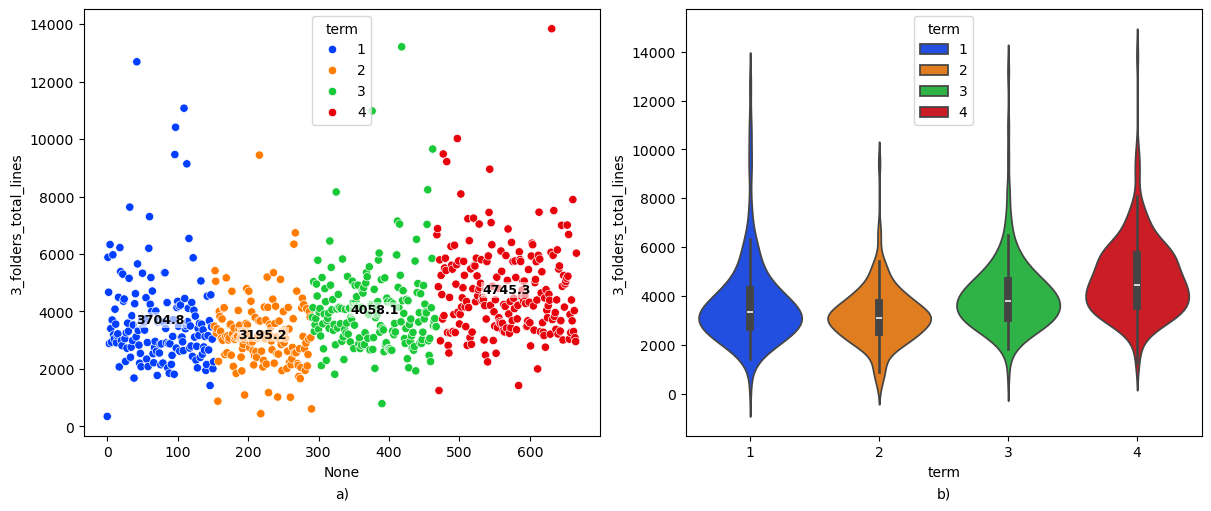

Saved: plot_3_folders_total_lines_251228.png


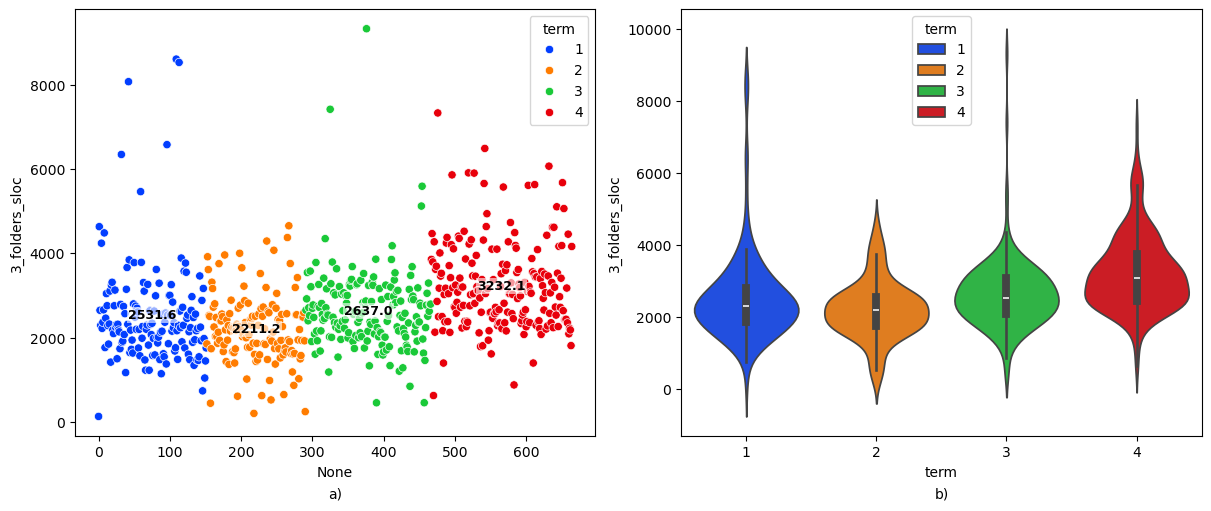

Saved: plot_3_folders_sloc_251228.png


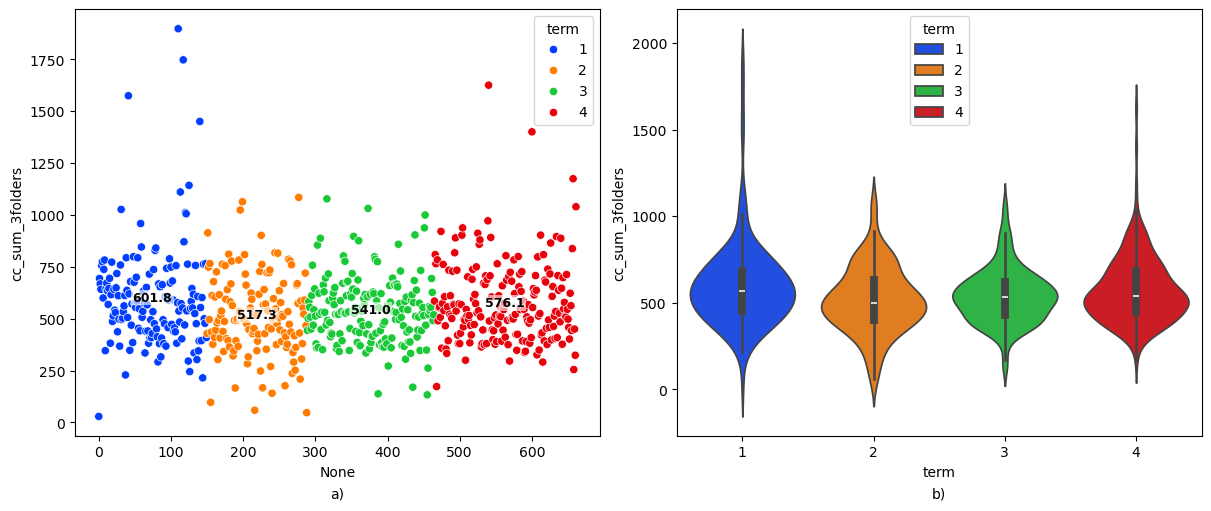

Saved: plot_cc_sum_3folders_251228.png


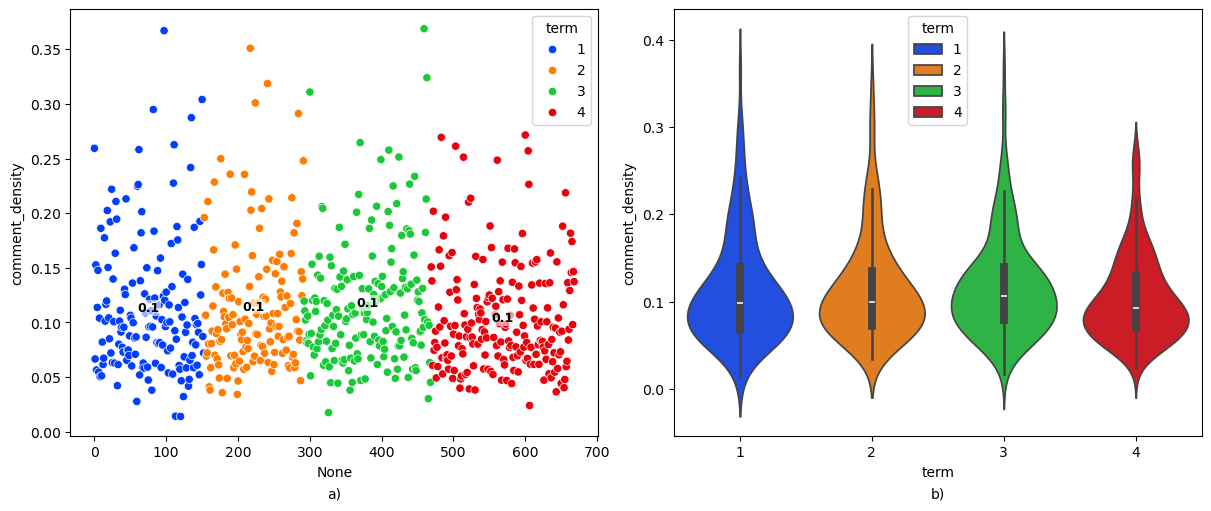

Saved: plot_comment_density_251228.png


In [14]:
df = pd.read_csv(cfg.project_level_dataset_path_cleaned)
cols = cfg.project_cols
dst = cfg.plots_path
plot_metrics_and_save(df, cols, out_dir=dst, save=True)

#### Plots Commit Level

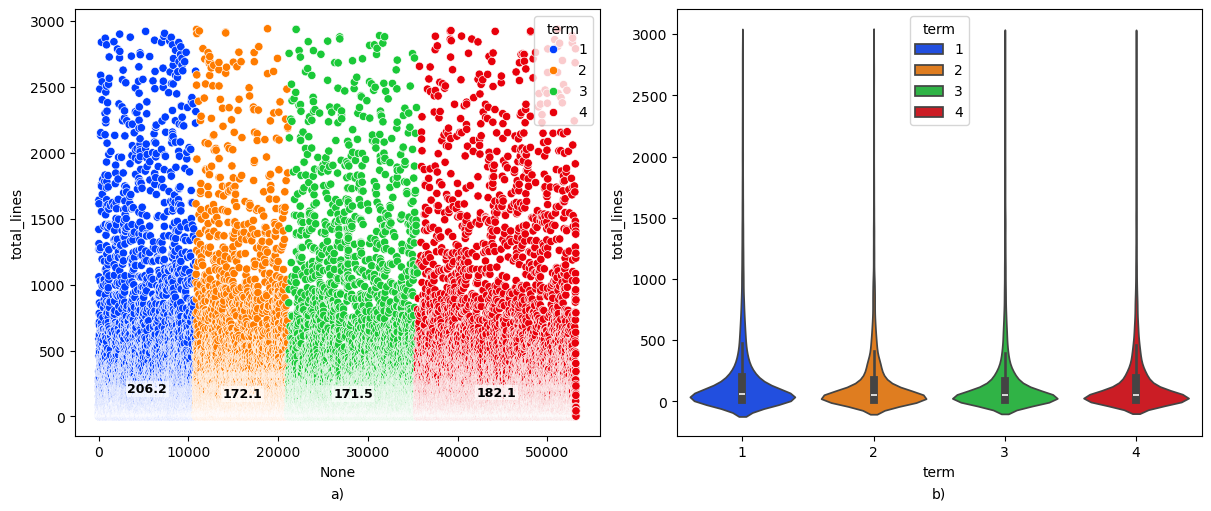

Saved: plot_total_lines_251228.png


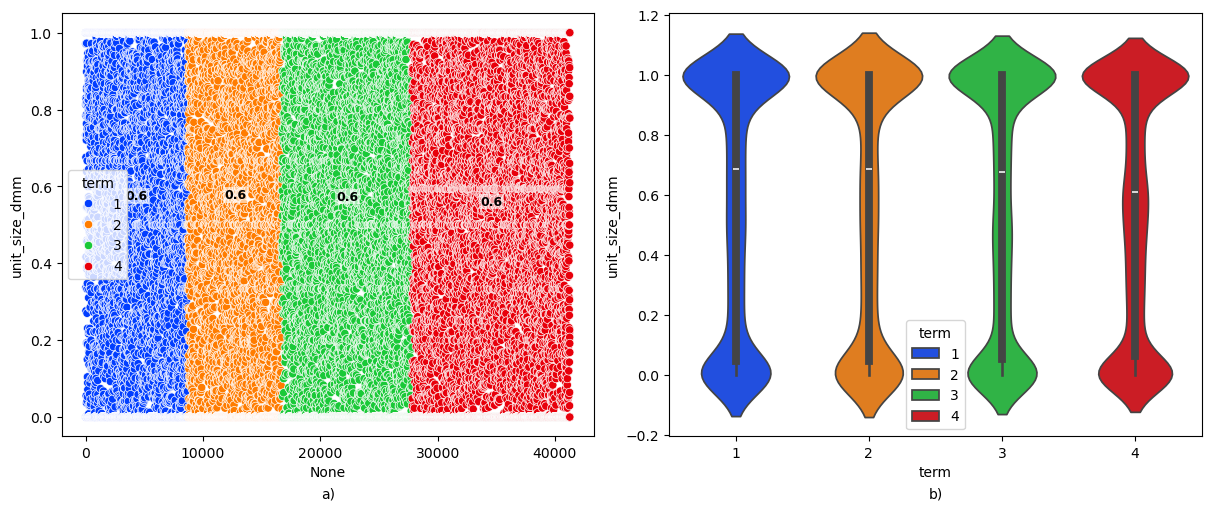

Saved: plot_unit_size_dmm_251228.png


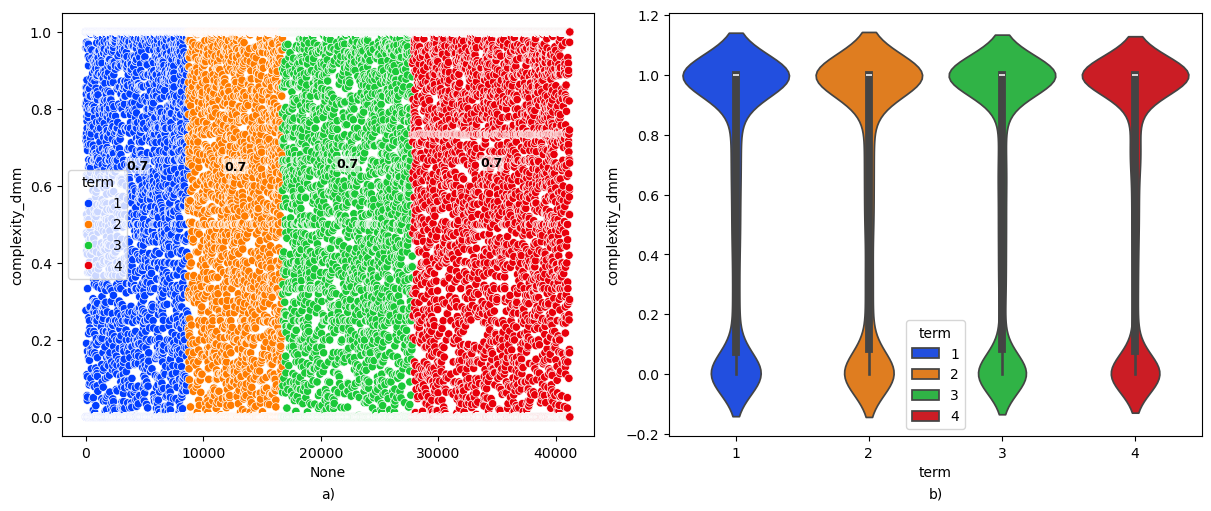

Saved: plot_complexity_dmm_251228.png


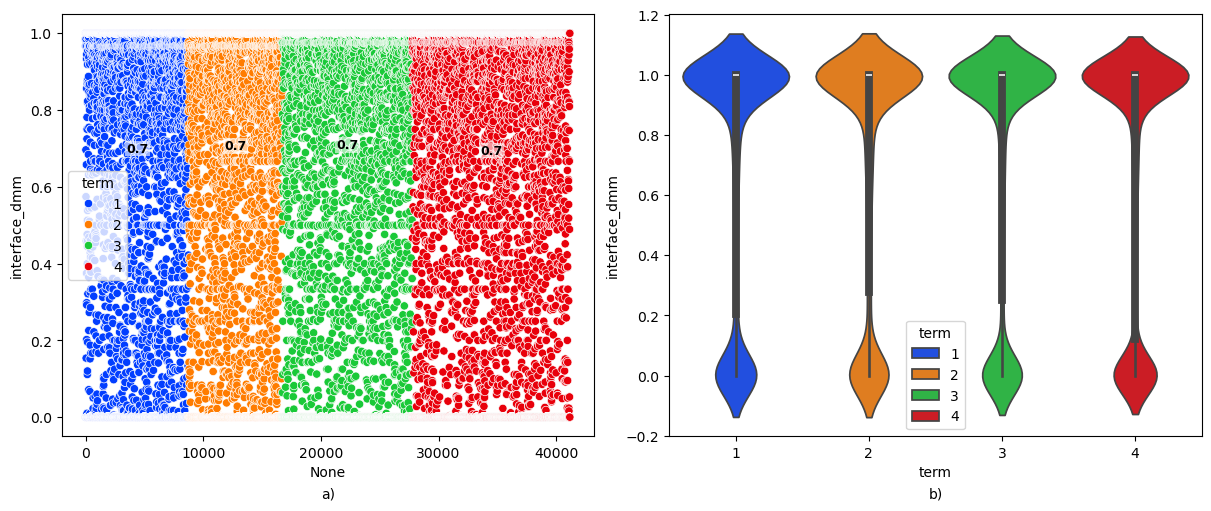

Saved: plot_interface_dmm_251228.png


In [15]:
df = pd.read_csv(cfg.commit_level_dataset_path_cleaned)
cols = cfg.commit_cols
dst = cfg.plots_path
plot_metrics_and_save(df, cols, out_dir=dst, save=True)

#### Plots Developer Level

##### Create Data

Why are there no bots in the most commits_per_developer? 
- Because the bot is threated as a separate developer for each project

In [16]:
def build_dev_project_metrics(df: pd.DataFrame) -> pd.DataFrame:
    """
    Build one row per (dev, project) with:
      dev, project, n_commits, contribution, commit_contribution_ratio, relative_code_churn

    Assumes:
      - each row in df is a commit record about a developer
      - df has columns: ['dev', 'project', 'total_lines']
    """
    required = {"dev", "project", "total_lines"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"df is missing required columns: {sorted(missing)}")

    # carry-through columns (do not affect grouping/ratios)
    passthrough_cols = [c for c in ["term", "genai_period"] if c in df.columns]

    # (1) dev-project aggregates
    agg_spec = {
        "n_commits": ("dev", "size"),
        "contribution": ("total_lines", "sum"),
        **{c: (c, "first") for c in passthrough_cols},
    }
    out = (
        df.groupby(["dev", "project"], as_index=False)
          .agg(**agg_spec)
    )

    # (2) project totals
    project_total_commits = df.groupby("project").size()
    project_total_lines = df.groupby("project")["total_lines"].sum()

    denom_commits = out["project"].map(project_total_commits).astype(float)
    denom_lines = out["project"].map(project_total_lines).astype(float)

    # (3) ratios (avoid division by zero)
    out["commit_contribution_ratio"] = np.where(
        denom_commits > 0, out["n_commits"].astype(float) / denom_commits, np.nan
    )
    out["relative_code_churn"] = np.where(
        denom_lines != 0, out["contribution"].astype(float) / denom_lines, np.nan
    )

    # (4) final shape + sort (optional)
    out = out[["dev", "project", *passthrough_cols, "n_commits", "contribution",
               "commit_contribution_ratio", "relative_code_churn"]].sort_values(
        by="project", ascending=True
    ).reset_index(drop=True)

    return out


In [17]:
df = pd.read_csv(cfg.commit_level_dataset_path_cleaned)
ndf = build_dev_project_metrics(df)
ndf.shape

(2059, 8)

In [18]:
# cleaning
invalid_projects = ndf.loc[(ndf["dev"] == 0) | (ndf["dev"] > 2), "project"].unique() # 83 projects
ndf_filtered = ndf.loc[~ndf["project"].isin(invalid_projects)].copy()
ndf_filtered.shape

(1734, 8)

In [19]:
# list of projects that have more than two developers and bots
proj = ndf[(ndf['dev'] == 0) | (ndf['dev'] > 2)]
proj['dev'].value_counts() # how these reasons, remaining devs and unclear developers, are disributed

dev
3.0    46
0.0    40
4.0     4
7.0     1
5.0     1
Name: count, dtype: int64

In [20]:
# list and number of projects that have more than two developers and bots
proj['project'].nunique()

83

In [21]:
proj.shape

(92, 8)

In [22]:
ndf_filtered.columns

Index(['dev', 'project', 'term', 'genai_period', 'n_commits', 'contribution',
       'commit_contribution_ratio', 'relative_code_churn'],
      dtype='object')

In [23]:
# rename column to match definitions
ndf_filtered = ndf_filtered.rename(columns={'n_commits': 'commits_per_developer'})
ndf_filtered = ndf_filtered.rename(columns={'contribution': 'contribution_per_developer'})

In [24]:
ndf_filtered.columns

Index(['dev', 'project', 'term', 'genai_period', 'commits_per_developer',
       'contribution_per_developer', 'commit_contribution_ratio',
       'relative_code_churn'],
      dtype='object')

In [25]:
# store at right place
store_path = cfg.dev_level_dataset_path_cleaned
# ndf_filtered.to_csv(store_path, index=False)

##### Create Plots

In [26]:
cndf = ndf_filtered

In [27]:
cndf.columns

Index(['dev', 'project', 'term', 'genai_period', 'commits_per_developer',
       'contribution_per_developer', 'commit_contribution_ratio',
       'relative_code_churn'],
      dtype='object')

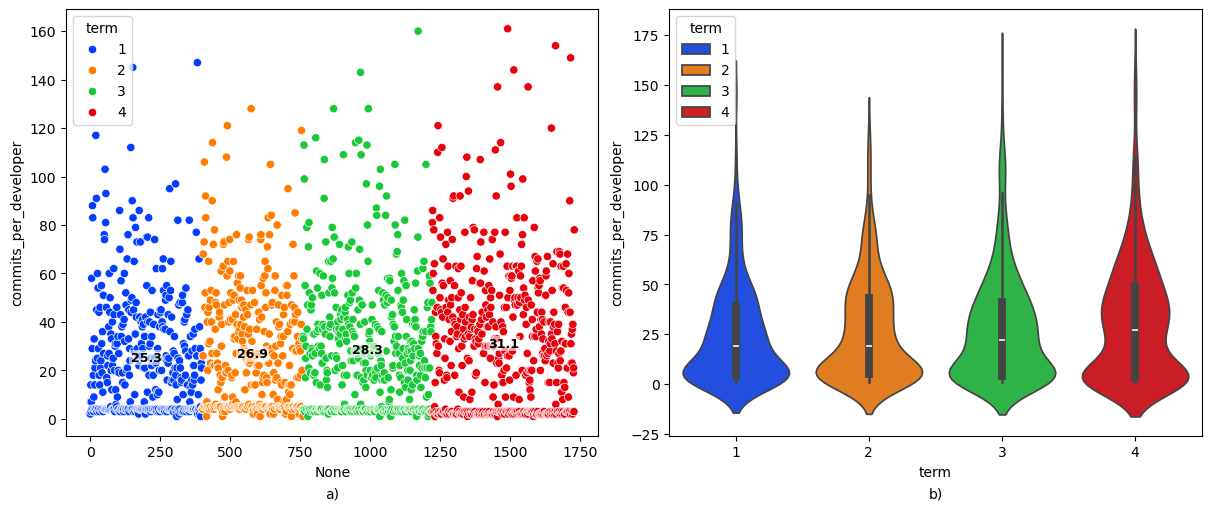

Saved: plot_commits_per_developer_251228.png


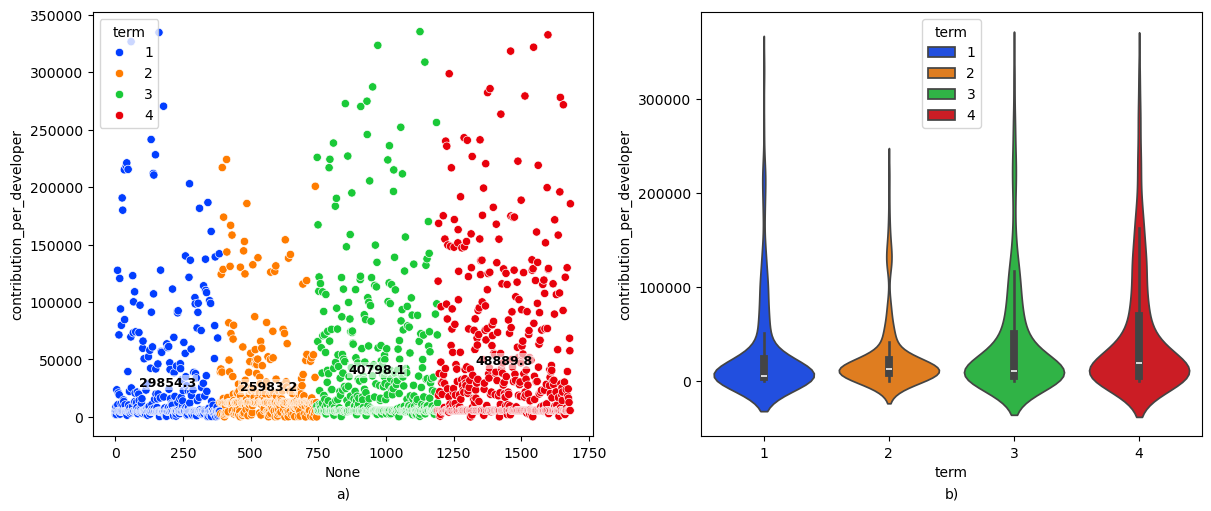

Saved: plot_contribution_per_developer_251228.png


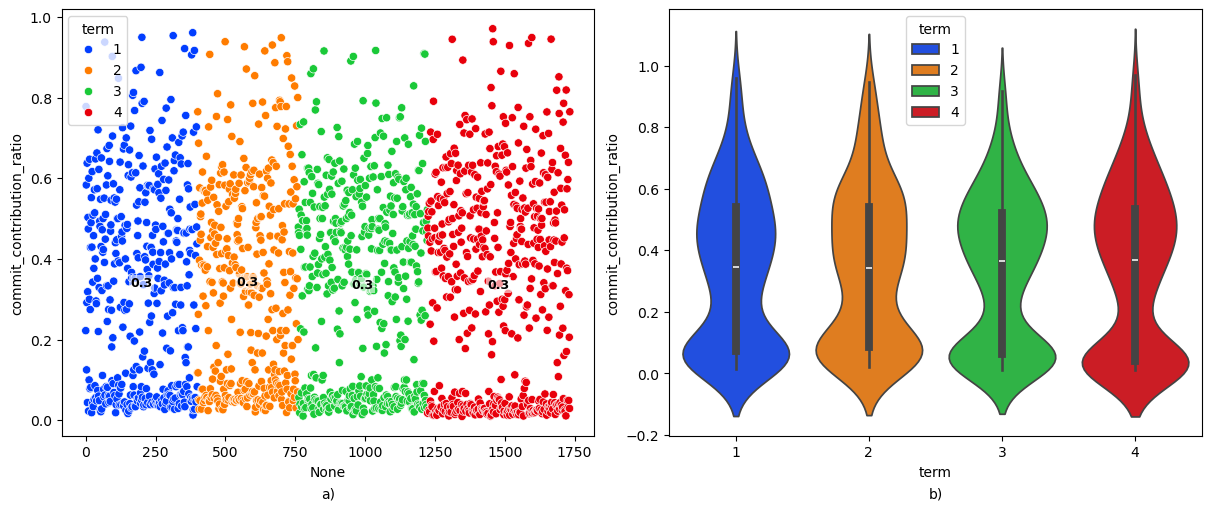

Saved: plot_commit_contribution_ratio_251228.png


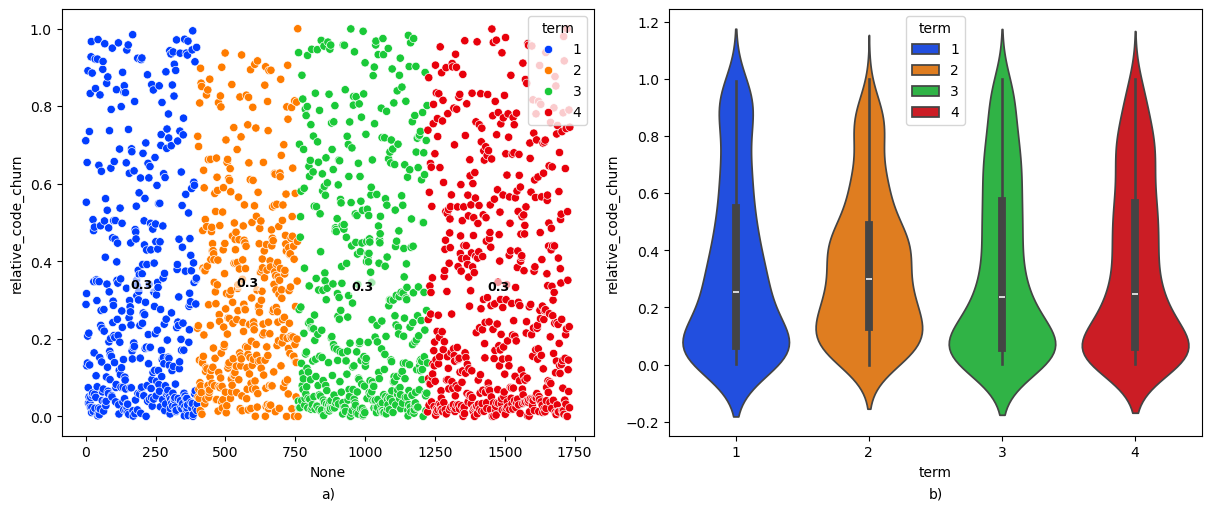

Saved: plot_relative_code_churn_251228.png


In [29]:
cndf
cols = cfg.dev_cols
dst = cfg.plots_path
plot_metrics_and_save(cndf, cols, out_dir=dst, save=True)

#### Random

TODO: Fix x-axis label is not None but the project index